In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose
import dm_control

import cv2

from flygym.util.turning_controller import TurningController
from flygym.util.cpg_controller import plot_phase_amp_output_rules, sine_output

In [3]:
# Initialize the simulation
enable_adhesion = True
run_time = 1.0
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_RFTarsus1_zoomin",
    render_playspeed=0.05,
    actuator_kp=30,
    enable_adhesion=True,
    draw_adhesion=True,
    draw_contacts=True,
    adhesion_gain=20,
)

stab_dur = 0.2

nmf = TurningController(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos=[0, 0, 0.2],
    stabilisation_dur=stab_dur,
)

num_steps_base = int(run_time / nmf.timestep)
num_steps = num_steps_base

In [4]:
np.random.seed(0)

obs, info = nmf.reset()
phases, amplitudes, obs_list = nmf.run_stabilisation(
    render_onset=stab_dur / nmf.timestep
)
stumble_active = [False] * len(phases)
retract_active = [False] * len(phases)
action = [1.0, 1.0]
for i in trange(num_steps):
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)

    render_status = nmf.render()
    if not render_status is None:
        last_frame = nmf.get_last_frame()
        cv2.putText(
            last_frame,
            f"{nmf.curr_time}",
            (10, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 0),
            2,
        )

    phases.append(nmf.cpg.phase)
    amplitudes.append(nmf.cpg.amplitude)

100%|██████████| 10000/10000 [00:37<00:00, 269.06it/s]


In [5]:
video_path = Path("adhesion_pannel/full_run.mp4")
nmf.save_video(video_path)

from ipywidgets import Video

Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [6]:
selected_timepoint = 1.00839999

# Run headless until you reach the selected frame

In [7]:
# Initialize the simulation
nmf = TurningController(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos=[0, 0, 0.2],
    stabilisation_dur=stab_dur,
)

np.random.seed(0)


nmf.sim_params.render_mode = "headless"

obs, info = nmf.reset()
_, _, _ = nmf.run_stabilisation(render_onset=stab_dur / nmf.timestep)

eps = 5e-5

action = [1.0, 1.0]
i = 0
while np.abs(nmf.curr_time - selected_timepoint) > nmf.timestep - eps and i < 10000:
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)

    i += 1

In [8]:
nmf.curr_time

1.0083999999999054

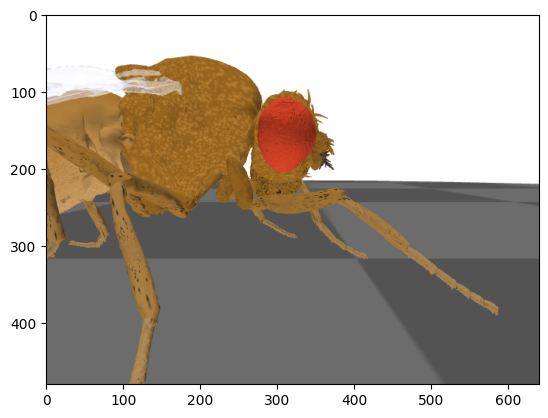

In [9]:
width, height = nmf.sim_params.render_window_size
cam = nmf.sim_params.render_camera

selected_img = nmf.physics.render(height, width, camera_id=cam)
plt.imshow(selected_img)

# save_img withtou arrows
plt.imsave("adhesion_pannel/selected_img.png", selected_img)

In [10]:
dm_camera = dm_control.mujoco.Camera(
    nmf.physics,
    camera_id=nmf.sim_params.render_camera,
    width=width,
    height=height,
)

scaling_factor = 0.05

camera_matrix = dm_camera.matrix
arrow_start_adh = nmf.physics.named.data.geom_xpos["Animat/RFTarsus5_collision"].copy()
arrow_end_adh = (
    arrow_start_adh
    + np.array([0.0, 0.0, -1.0]) * nmf.sim_params.adhesion_gain * scaling_factor
)

arrow_starts_contact = []
arrow_ends_contact = []
for i in range(1, 6):
    index_RFTarsus_contact = nmf.contact_sensor_placements.index(f"Animat/RFTarsus{i}")
    arrow_starts_contact.append(
        nmf.physics.named.data.geom_xpos[f"Animat/RFTarsus{i}_collision"].copy()
    )
    arrow_ends_contact.append(
        arrow_starts_contact[-1]
        + obs["contact_forces"][:, index_RFTarsus_contact] * scaling_factor
    )

arrows_contacts = np.hstack([arrow_starts_contact, arrow_ends_contact]).reshape((-1, 3))

xyz_global = np.vstack([arrow_start_adh, arrow_end_adh, arrows_contacts]).T

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = camera_matrix @ corners_homogeneous

# x and y are in the pixel coordinate system.
x = np.rint(xs / s).astype(int)
y = np.rint(ys / s).astype(int)

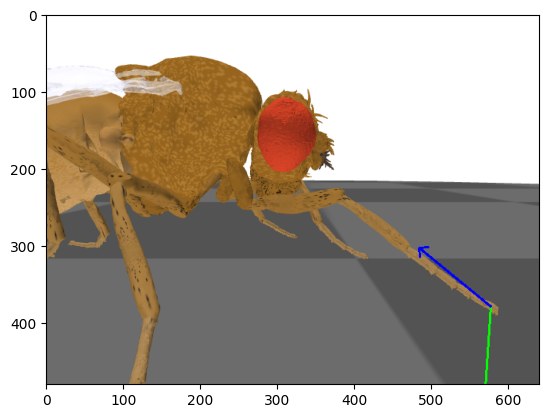

In [11]:
selected_img = nmf.physics.render(height, width, camera_id=cam)

rgb_contact = (0, 0, 255)
rgb_adhesion = (0, 255, 0)

img = selected_img.astype(np.uint8)
for i in range(0, len(x), 2):
    pts1 = x[i], y[i]
    pts2 = x[i + 1], y[i + 1]
    rgb = rgb_contact
    if i == 0:
        rgb = rgb_adhesion
    if not np.any(pts1 == pts2):
        selected_img = cv2.arrowedLine(img, pts1, pts2, rgb, 2)
# add text
font = cv2.FONT_HERSHEY_SIMPLEX
# img = cv2.putText(img, 'FAdhesion', (width-200, 30), font, 1, rgb_adhesion, 2, cv2.LINE_AA)
# img = cv2.putText(img, 'FContact', (width-200, 60), font, 1, rgb_contact, 2, cv2.LINE_AA)

plt.imshow(selected_img)

plt.imsave("adhesion_pannel/selected_img_arrows.png", selected_img)